**1. Prerequisites**

In [0]:
%sh pip install nltk


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [0]:
%sh pip install textblob

  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/02/07/5fd2945356dd839974d3a25de8a142dc37293c21315729a41e775b5f3569/textblob-0.18.0.post0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 16.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.functions import corr

from textblob import TextBlob

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords') 
nltk.download('wordnet') 
nltk.download('punkt') 

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**2. Preprocessing**

In [0]:
spark = SparkSession.builder \
.appName("BitcoinTweets") \
.getOrCreate()

schema = T.StructType([
T.StructField("id", T.StringType(), True),
T.StructField("user", T.StringType(), True),
T.StructField("fullname", T.StringType(), True),
T.StructField("url", T.StringType(), True),
T.StructField("timestamp", T.TimestampType(), True),
T.StructField("replies", T.FloatType(), True),
T.StructField("likes", T.FloatType(), True),
T.StructField("retweets", T.FloatType(), True),
T.StructField("text", T.StringType(), True)
])

df = spark.read \
.option("header", "true") \
.option("multiLine", "true") \
.schema(schema) \
.csv("/FileStore/tables/bitcoin_tweets.csv")

columns_to_drop = ["user", "fullname", "url"]
df = df.drop(*columns_to_drop)

df = df.dropna(subset=['timestamp', 'text']).dropDuplicates(['timestamp', 'text'])

def clean_text(text):
    if text:
        text = text.lower().strip()
        text = re.sub(r'http\S+|www\S+|https\S+','',text)
        text = re.sub(r'@\w+','',text)
        text = re.sub(r'#\w+','',text)
        text = re.sub(r'[^A-Za-z\s]','',text)
        return text.strip()
    else:
        return None

clean_text_udf = F.udf(clean_text, T.StringType())
df = df.withColumn("cleaned_text", clean_text_udf(F.col("text")))

df = df.dropna(subset=["cleaned_text"]).filter(F.col("cleaned_text") !="")

df = df.withColumn("cleaned_text_array",F.split(F.col("cleaned_text")," "))

nltk_stopwords = set(stopwords.words('english'))

remover = StopWordsRemover(inputCol="cleaned_text_array", outputCol="filtered_text", stopWords=list(nltk_stopwords))

df = remover.transform(df)

lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text_array):
    if text_array:
        tokens = [lemmatizer.lemmatize(token) for token in text_array]
        lemmatized_text = ' '.join(tokens)
        lemmatized_text = re.sub(r'\s+',' ', lemmatized_text)
        return lemmatized_text.strip()
    else:
        return None

tokenize_and_lemmatize_udf = F.udf(tokenize_and_lemmatize, T.StringType())

df = df.withColumn("lemmatized_text", tokenize_and_lemmatize_udf(F.col("filtered_text")))

output_path = "/FileStore/tables/cleaned_bitcoin_tweets.csv"

selected_columns = ["id","timestamp","replies","likes","retweets","lemmatized_text"]

df.select(selected_columns) \
    .write \
    .mode("overwrite") \
    .csv(output_path, header=True)

**3. Loading DataFrame**

In [0]:
schema = T.StructType([
T.StructField("id", T.StringType(), True),
T.StructField("timestamp", T.TimestampType(), True),
T.StructField("replies", T.FloatType(), True),
T.StructField("likes", T.FloatType(), True),
T.StructField("retweets", T.FloatType(), True),
T.StructField("lemmatized_text", T.StringType(), True)
])

df = spark.read \
.option("header", "true") \
.option("multiLine", "true") \
.schema(schema) \
.csv("/FileStore/tables/cleaned_bitcoin_tweets.csv")

In [0]:
display(df.limit(100))

id,timestamp,replies,likes,retweets,lemmatized_text
4.1385138633886925e+17,2013-12-20T01:00:34Z,0.0,2.0,2.0,btc gbp january exchange rate
6.673650485079572e+17,2015-11-19T14:33:21Z,18.0,304.0,219.0,banning bitcoin the picture contains signed bitcoin transaction worth usd joke
7.35349204168659e+17,2016-05-25T03:58:07Z,0.0,0.0,0.0,ethereum price technical analysis resistance
7.429599385788539e+17,2016-06-15T04:00:27Z,0.0,0.0,0.0,ethereum price technical analysis eth sighting
7.42961283285291e+17,2016-06-15T04:05:48Z,0.0,0.0,0.0,ethereum price technical analysis eth sighting
7.840162893584179e+17,2016-10-06T11:03:44Z,0.0,4.0,2.0,first looked bitcoin see video contact
8.16631546207572e+17,2017-01-04T12:05:07Z,0.0,0.0,0.0,cap
8.250705460188283e+17,2017-01-27T19:58:41Z,19.0,267.0,155.0,central banking created debt serfdom simple get changing money changing world bitcoin
8.67473355905151e+17,2017-05-24T18:12:19Z,1.0,2.0,0.0,broke ea thanks japan legislation good day encryption coin holder
8.679000153892864e+17,2017-05-25T22:27:43Z,0.0,1.0,0.0,provide everything thought wanted get value pictwittercomckflxxwdb


**4. Sentiment Analysis**

In [0]:
def analyze_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

sentiment_udf = F.udf(analyze_sentiment, F.StringType())

df = df.withColumn("sentiment", sentiment_udf(df["lemmatized_text"]))

df = df.filter(F.col("lemmatized_text").isNotNull())

df = df.withColumn("date", F.date_format("timestamp", "yyyy-MM-dd"))

df.show()

+--------------------+-------------------+-------+------+--------+--------------------+---------+----------+
|                  id|          timestamp|replies| likes|retweets|     lemmatized_text|sentiment|      date|
+--------------------+-------------------+-------+------+--------+--------------------+---------+----------+
|4.138513863388692...|2013-12-20 01:00:34|    0.0|   2.0|     2.0|btc gbp january e...|  neutral|2013-12-20|
|6.673650485079572...|2015-11-19 14:33:21|   18.0| 304.0|   219.0|banning bitcoin t...| positive|2015-11-19|
|7.35349204168659e+17|2016-05-25 03:58:07|    0.0|   0.0|     0.0|ethereum price te...|  neutral|2016-05-25|
|7.429599385788539...|2016-06-15 04:00:27|    0.0|   0.0|     0.0|ethereum price te...|  neutral|2016-06-15|
|7.42961283285291e+17|2016-06-15 04:05:48|    0.0|   0.0|     0.0|ethereum price te...|  neutral|2016-06-15|
|7.840162893584179...|2016-10-06 11:03:44|    0.0|   4.0|     2.0|first looked bitc...| positive|2016-10-06|
|8.16631546207572e+

The analyze_sentiment function takes a text as input and a TextBlob object is created for the input text.
The polarity of the text is determined and the corresponding sentiment is returned: positive if the polarity is greater than 0; negative if the polarity is less than 0 and neutral if the polarity is equal to 0.
The analyze_sentiment function is registered as a User-Defined Function (UDF) to be used with Spark DataFrame. The UDF is applied to the DataFrame to create a new "sentiment" column containing the result of the sentiment analysis for each row. The rows that have a null lemmatized_text are filtered.
A new date column in the format "yyyy-MM-dd" is created from the "timestamp" column. The updated DataFrame with the new "sentiment" column is displayed.


**5. Sentiment Change Day by Day**

In [0]:
daily_sentiment = df.groupBy("date", "sentiment").count().orderBy("date")

daily_sentiment.show()

+----------+---------+-----+
|      date|sentiment|count|
+----------+---------+-----+
|2009-01-11|  neutral|    1|
|2012-08-02| positive|    1|
|2012-09-20|  neutral|    1|
|2012-11-17|  neutral|    1|
|2013-08-16| positive|    1|
|2013-12-09|  neutral|    1|
|2013-12-19|  neutral|    1|
|2013-12-20|  neutral|    1|
|2014-02-20| positive|    1|
|2014-07-12|  neutral|    1|
|2014-08-01|  neutral|    1|
|2014-10-03|  neutral|    1|
|2014-12-12|  neutral|    1|
|2015-02-14|  neutral|    1|
|2015-09-02| positive|    1|
|2015-10-21|  neutral|    1|
|2015-11-19| positive|    1|
|2016-02-19|  neutral|    1|
|2016-03-28|  neutral|    3|
|2016-05-03|  neutral|    2|
+----------+---------+-----+
only showing top 20 rows



The DataFrame is grouped by the date and sentiment columns. The sentiment count is calculated for each combination of date and sentiment. The results are sorted by date. Shows the resulting DataFrame with the sentiment count by date and sentiment type, providing a detailed overview of the sentiment trend over time.

**6. Depiction of the Evolution of Public Sentiment towards Bitcoin**

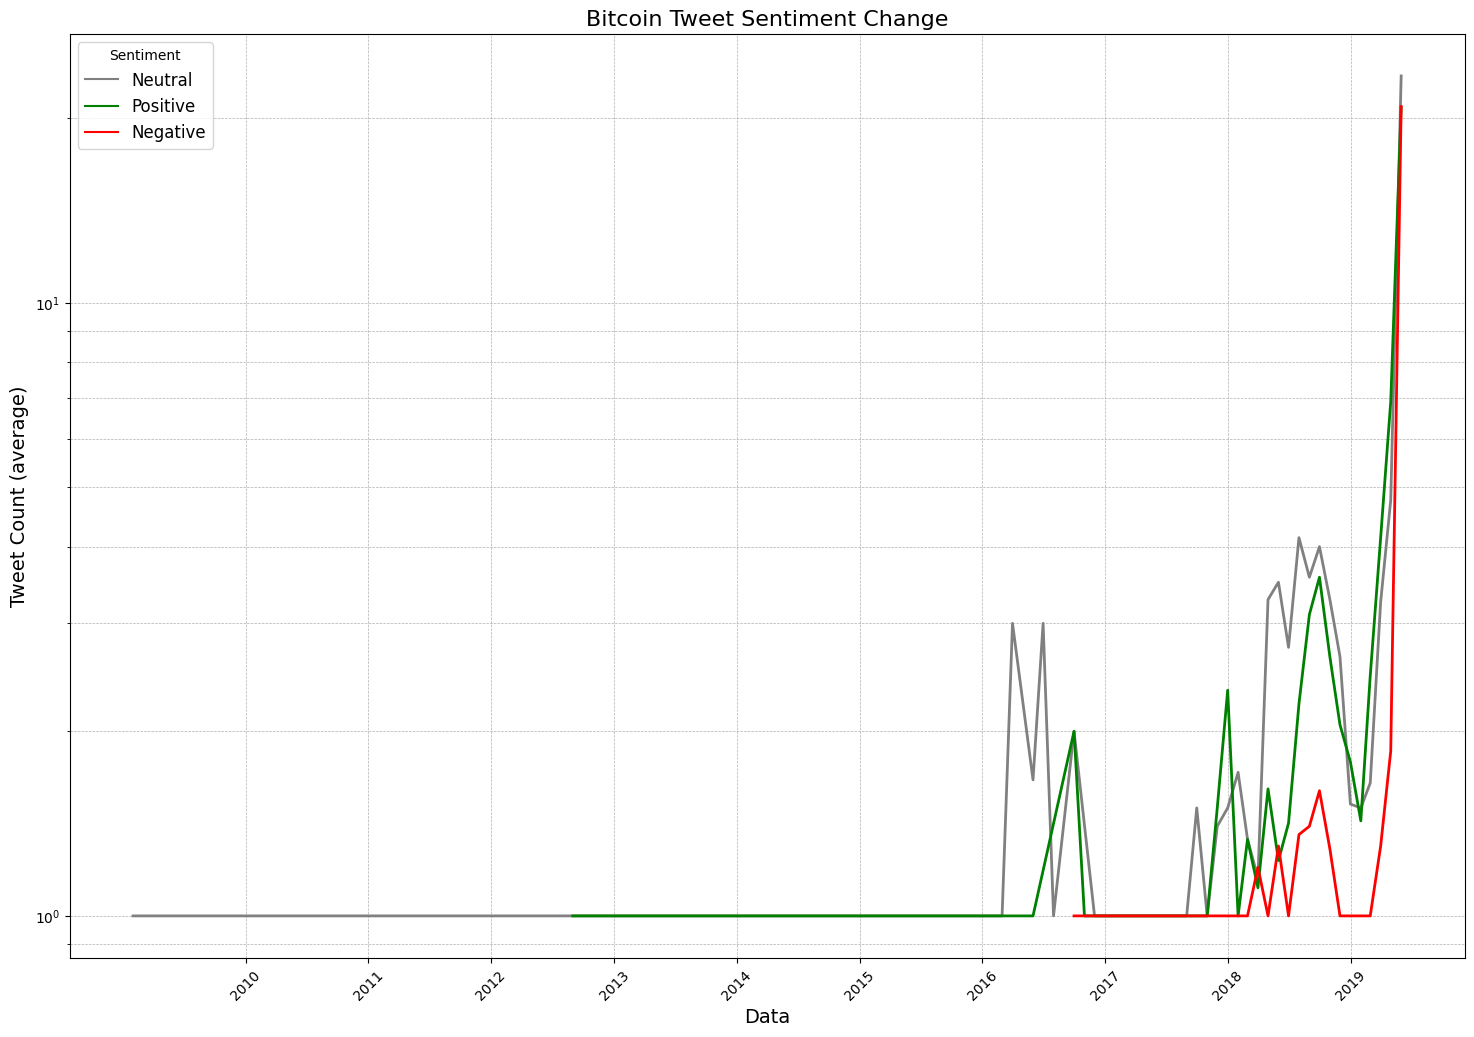

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

pdf = daily_sentiment.toPandas()

pdf['date'] = pd.to_datetime(pdf['date'])
pdf.set_index('date', inplace=True)

lower_bound = pdf['count'].quantile(0.01)  
upper_bound = pdf['count'].quantile(0.99)  
pdf_filtered = pdf[(pdf['count'] >= lower_bound) & (pdf['count'] <= upper_bound)]

pdf_monthly = pdf_filtered.groupby([pd.Grouper(freq='M'), 'sentiment'])['count'].mean().reset_index()

custom_colors = {'neutral': 'gray', 'positive': 'green', 'negative': 'red'}

palette = [custom_colors[sentiment] for sentiment in pdf_filtered['sentiment'].unique()]

plt.figure(figsize=(18, 12))

sns.lineplot(data=pdf_monthly, x="date", y="count", hue="sentiment", palette=custom_colors, linewidth=2)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(pd.date_range(pdf_monthly['date'].min(), pdf_monthly['date'].max(), freq='YS'), rotation=45)

plt.title('Bitcoin Tweet Sentiment Change', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Tweet Count (average)', fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Neutral', 'Positive', 'Negative'], title='Sentiment', fontsize=12)

plt.yscale('log')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

**7. Analysis of Engagement generated by Tweets**

In [0]:
interactions_stats = df.groupBy("sentiment").agg(
    F.avg("likes").alias("avg_likes"),
    F.stddev("likes").alias("stddev_likes"), 
    F.avg("replies").alias("avg_replies"),
    F.stddev("replies").alias("stddev_replies") 
)

interactions_stats.show()

+---------+------------------+------------------+------------------+------------------+
|sentiment|         avg_likes|      stddev_likes|       avg_replies|    stddev_replies|
+---------+------------------+------------------+------------------+------------------+
| positive| 9.740014358438845| 89.12527080084162|1.3611147369795067| 21.50804248497393|
|  neutral| 5.959068046482049|103.02756612005871| 0.576169277909464| 9.406764428611954|
| negative|11.556170028193451|110.29360330027484| 1.242788982867057|11.374830497168697|
+---------+------------------+------------------+------------------+------------------+



**Did negative tweets get more likes than positive tweets?**

Negative tweets showed higher average of likes than positive tweets. It is important to note that the standard deviation for likes for negative tweets is significantly higher than that for positive tweets. This indicates that while negative tweets got more likes on average, there is also more variability in the like results for these tweets than for positive tweets.

**Did negative tweets get more interactions than positive tweets?**

Positive tweets showed a slightly higher average of replies than negative tweets. However, the difference is small. The standard deviation of replies for negative tweets is lower than that for positive tweets, indicating that responses to negative tweets are less variable than to positive tweets.

**8. Relationship between Sentiment Change and Bitcoin Value Change**

In [0]:
price_schema = T.StructType([
T.StructField("timestamp", T.TimestampType(), True),
T.StructField("price", T.FloatType(), True)
])

price_df = spark.read \
.option("header", "true") \
.option("multiLine", "true") \
.schema(price_schema) \
.csv("/FileStore/tables/Bitcoin_price_USD.csv")

price_df = price_df.withColumn("date", F.date_format("timestamp", "yyyy-MM-dd")).drop("timestamp")

price_df.show()

+-----+----------+
|price|      date|
+-----+----------+
| 0.09|2010-07-18|
| 0.08|2010-07-19|
| 0.07|2010-07-20|
| 0.08|2010-07-21|
| 0.05|2010-07-22|
| 0.06|2010-07-23|
| 0.05|2010-07-24|
| 0.05|2010-07-25|
| 0.06|2010-07-26|
| 0.06|2010-07-27|
| 0.06|2010-07-28|
| 0.07|2010-07-29|
| 0.06|2010-07-30|
| 0.07|2010-07-31|
| 0.06|2010-08-01|
| 0.06|2010-08-02|
| 0.06|2010-08-03|
| 0.06|2010-08-04|
| 0.06|2010-08-05|
| 0.06|2010-08-06|
+-----+----------+
only showing top 20 rows



In [0]:
joined_df = daily_sentiment.join(price_df, on="date", how="inner")
joined_df.show()

correlation_df = joined_df.groupBy("sentiment").agg(
corr("count", "price").alias("correlation")
)
correlation_df.show()

+----------+---------+-----+---------+
|      date|sentiment|count|    price|
+----------+---------+-----+---------+
|2018-02-21| negative|    1| 10456.17|
|2018-06-24| positive|    4|  6150.19|
|2018-09-02|  neutral|    9| 7200.105|
|2018-09-25| positive|    4| 6583.027|
|2019-05-04|  neutral|   11|5812.3315|
|2015-11-19| positive|    1|   326.31|
|2017-06-06| positive|    1|  2914.08|
|2018-07-26| negative|    1|  7929.61|
|2018-08-26| positive|    6|  6707.63|
|2018-12-05|  neutral|    1|3901.2253|
|2019-03-13|  neutral|    4|3846.2744|
|2018-11-24|  neutral|    1|  4287.81|
|2019-01-12|  neutral|    2|3611.5283|
|2018-11-22|  neutral|    2|  4536.72|
|2018-12-10|  neutral|    1|3528.1296|
|2019-05-03|  neutral|   14| 5697.679|
|2018-04-09| positive|    1|  6773.94|
|2018-06-23| positive|    1|  6170.56|
|2018-10-15|  neutral|    7| 6341.381|
|2017-01-27|  neutral|    1|   918.56|
+----------+---------+-----+---------+
only showing top 20 rows

+---------+--------------------+
|sent

The data shows the correlation between tweet sentiment (positive, neutral, negative) and the price of Bitcoin. Here's what we can infer from this data: 1. Positive correlations: All three sentiments (positive, neutral, negative) show a positive correlation with the price of Bitcoin. This means that when the sentiment (regardless of whether it is positive, neutral, or negative) increases, there tends to be a related increase in the price of Bitcoin. 2. Correlation strength: The correlation value is similar across the different sentiments: positive, neutral, negative. This suggests that there is not a large difference in the strength of the correlation between the different types of sentiment. All three have a relatively modest correlation with the price of Bitcoin. 3. Results: The positive correlation indicates that tweet sentiment is generally in line with the price movements of Bitcoin. However, the correlation does not necessarily imply a direct causal relationship. It is possible that tweet sentiment reflects the overall market sentiment, thereby influencing or reacting to the price of Bitcoin. Other factors may simultaneously influence both tweet sentiment and the price of Bitcoin. The correlation may vary over time and may be influenced by external events. In summary, from the data provided it can be deduced that there is a positive correlation between the price of Bitcoin and tweet sentiment (both positive, neutral, and negative), indicating that changes in sentiment may be associated with changes in the price of Bitcoin.

**9. Merging Sentiment Data with Bitcoin Price Data**

In [0]:
conversion_expr = F.when(F.col("sentiment") == "positive", 1) \
                    .when(F.col("sentiment") == "neutral", 0) \
                    .when(F.col("sentiment") == "negative", -1)

daily_sentiment_avg = daily_sentiment.withColumn("numerical_sentiment", conversion_expr) \
                                     .groupBy("date") \
                                     .agg(F.avg("numerical_sentiment").alias("avg_sentiment"))

joined_df = daily_sentiment_avg.join(price_df, on="date", how="inner")
joined_df = joined_df.select("date", "avg_sentiment", "price")
joined_df.show()

+----------+-------------+---------+
|      date|avg_sentiment|    price|
+----------+-------------+---------+
|2017-12-05|          0.5| 11696.06|
|2019-04-25|          0.5|5132.2275|
|2018-12-31|          1.0|3689.5647|
|2018-08-23|          0.0|  6525.61|
|2018-04-11|          0.0|  6939.55|
|2019-04-08|          0.5| 5260.205|
|2018-12-17|          0.5|3199.1665|
|2019-04-26|          0.5|5151.5747|
|2018-05-15|          0.0|  8474.24|
|2019-01-17|          0.5|3623.7173|
|2018-12-20|          1.0| 3684.244|
|2019-01-24|          0.5|3562.9204|
|2018-12-22|          0.0|3838.2415|
|2017-09-12|          1.0|  4148.27|
|2018-05-03|         -0.5|  9734.67|
|2018-10-10|          0.5| 6653.378|
|2018-12-30|          0.5| 3684.244|
|2018-06-22|          0.0|   6053.9|
|2018-11-13|          0.5|6321.5645|
|2018-08-24|          0.5|  6692.62|
+----------+-------------+---------+
only showing top 20 rows



In [0]:
window_spec = Window.orderBy("date")

joined_df = joined_df.withColumn("prev_avg_sentiment", F.lag("avg_sentiment").over(window_spec))
joined_df = joined_df.withColumn("prev_price", F.lag("price").over(window_spec))

joined_df = joined_df.withColumn("sentiment_change", F.col("avg_sentiment") - F.col("prev_avg_sentiment"))
joined_df = joined_df.withColumn("price_change", F.col("price") - F.col("prev_price"))

joined_df = joined_df.filter(F.col("prev_avg_sentiment").isNotNull() & F.col("prev_price").isNotNull())

joined_df.show()

+----------+-------------+------+------------------+----------+----------------+------------+
|      date|avg_sentiment| price|prev_avg_sentiment|prev_price|sentiment_change|price_change|
+----------+-------------+------+------------------+----------+----------------+------------+
|2012-09-20|          0.0| 12.28|               1.0|     10.53|            -1.0|        1.75|
|2012-11-17|          0.0| 11.79|               0.0|     12.28|             0.0| -0.48999977|
|2013-08-16|          1.0| 98.33|               0.0|     11.79|             1.0|       86.54|
|2013-12-09|          0.0|898.02|               1.0|     98.33|            -1.0|      799.69|
|2013-12-19|          0.0|698.45|               0.0|    898.02|             0.0|     -199.57|
|2013-12-20|          0.0|622.84|               0.0|    698.45|             0.0|  -75.609985|
|2014-02-20|          1.0|552.21|               0.0|    622.84|             1.0|  -70.630005|
|2014-07-12|          0.0|634.48|               1.0|    552.

**10. Study of the Correlation between Sentiment and Bitcoin Price**

In [0]:
correlation = joined_df.stat.corr("sentiment_change", "price_change")

print(f"Correlation between sentiment change and Bitcoin value change: {correlation}")

Correlation between sentiment change and Bitcoin value change: 0.024635589197272368


This correlation shows a slight positive relationship between the change in sentiment and the change in the value of Bitcoin.

This low value correlation (near zero) indicates that there is no significant or consistent relationship between the change in sentiment (likely measured via sentiment analysis on social media or other sources) and the change in the value of Bitcoin. While the sentiment of market participants may change (e.g., from positive to negative or vice versa), these changes have a slight effect on the price of Bitcoin.